🔧 Paso 1: Instalación de Ultralytics

In [3]:
!pip install ultralytics roboflow tfrecord tensorflow protobuf opencv-python-headless


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━

In [1]:
import os
import io
import cv2
import pandas as pd

🚀 Conversión desde CSV a formato YOLO

In [ ]:
# 📂 Crear carpetas para imágenes y anotaciones
!mkdir -p yolo_dataset/images/train yolo_dataset/labels/train

In [ ]:
!mkdir -p yolo_dataset/images/val yolo_dataset/labels/val

In [ ]:
# Leer csv
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
# 🔧 Crear un diccionario de clases
class_names = df_train['class'].unique().tolist()
class_dict = {name: i for i, name in enumerate(class_names)}

In [ ]:
class_dict

{'carro': 0, 'motos': 1}

In [ ]:
df_test['filename'].unique()

array(['8a98fca468.jpg', '6f65ac7a0a.jpg', '37e9f4c722.jpg',
       '533dd3ae49.jpg', '744ca71f5a.jpg', '576c712438.jpg',
       '0414eb4d03.jpg', '8e933395c2.jpg', '7490c9ba04.jpg',
       '95614aebd9.jpg', 'abdbb7257d.jpg', '38073088aa.jpg',
       'e9379064f8.jpg', 'e79711e10f.jpg', 'e02950195f.jpg',
       'b59018d131.jpg', 'c554e9b7b4.jpg', 'ea2cb5917b.jpg'], dtype=object)

In [2]:
import zipfile

In [ ]:
#Extraer archivo zip
with zipfile.ZipFile('/content/Finaldatset.zip', 'r') as zip_ref:
    zip_ref.extractall('Finaldataset')



In [ ]:
def Agrupacion (df,path,dataset):
# 🔁 Agrupar anotaciones por imagen
  for img_file, group in df.groupby("filename"):
      # Leer imagen
      image_path = path+"/"+img_file
      if not os.path.exists(image_path):
          print(f"Imagen no encontrada: {image_path}")
          continue

      img = cv2.imread(image_path)
      h, w = img.shape[:2]

      # Copiar imagen
      os.system(f"cp '{image_path}' yolo_dataset/images/{dataset}/{img_file}")

      # Crear archivo de anotaciones
      label_path = f"yolo_dataset/labels/{dataset}/{img_file.replace('.jpg', '.txt')}"
      with open(label_path, "w") as f:
          for _, row in group.iterrows():
              class_id = class_dict[row['class']]
              x_center = ((row['xmin'] + row['xmax']) / 2) / w
              y_center = ((row['ymin'] + row['ymax']) / 2) / h
              box_width = (row['xmax'] - row['xmin']) / w
              box_height = (row['ymax'] - row['ymin']) / h
              f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")


In [ ]:
path_train = '/content/Finaldataset/Finaldatset/train'
path_test = '/content/Finaldataset/Finaldatset/test'

In [ ]:
dataset = 'val'

In [ ]:
Agrupacion(df_test,path_test,dataset)

In [ ]:
import yaml

with open("yolo_dataset/data.yaml", "w") as f:
    yaml.dump({
        'path': os.path.abspath("yolo_dataset"),
        'train': 'images/train',
        'val': 'images/val',  # cambia si tienes otro set de validación
        'nc': len(class_names),
        'names': class_names
    }, f)


🧠 Paso 4: Entrenar YOLOv8



In [ ]:
from ultralytics import YOLO

# Crear modelo desde base preentrenada
model = YOLO('yolov8n.pt')

# Entrenar con tus datos
model.train(data="yolo_dataset/data.yaml", epochs=30, imgsz=640)


📈 Paso 5: Ver resultados

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# 📁 Leer resultados
df = pd.read_csv("runs/detect/train/results.csv")
print("Resumen de métricas:")
df.head()


Resumen de métricas:


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.73926,1.38891,3.13487,1.38711,0.00464,0.39423,0.16392,0.11036,1.43961,3.35018,1.17490,0.000033,0.000033,0.000033
1,2,4.98336,1.37190,3.24171,1.30567,0.00522,0.42308,0.22233,0.15307,1.43466,3.32577,1.17687,0.000081,0.000081,0.000081
2,3,6.13271,1.22190,2.92245,1.23512,0.00589,0.47692,0.30056,0.17502,1.36328,3.24396,1.11703,0.000125,0.000125,0.000125
3,4,7.29162,1.29247,2.57563,1.21263,0.00641,0.52115,0.30441,0.17047,1.37871,3.16766,1.12781,0.000165,0.000165,0.000165
4,5,8.95434,1.24134,2.01877,1.22276,0.00622,0.49615,0.30055,0.19838,1.44979,3.02885,1.14740,0.000203,0.000203,0.000203


Analogía general para entender las métricas
Imagina que estás entrenando a alguien para reconocer frutas en fotos:

Métrica	Analogía
- precision:	De todas las veces que dijo “¡banana!”, ¿cuántas veces realmente era una banana?
- recall	:De todas las bananas que había en la imagen, ¿cuántas encontró?
- mAP@0.5	:¿Qué tan bien dibujó los cuadros alrededor de cada fruta, aunque no fueran perfectos?
- mAP@0.5:0.95	:¿Qué tan bien lo hizo cuando se le exigía dibujar casi perfecto?


Precision promedio:  0.7514430000000001


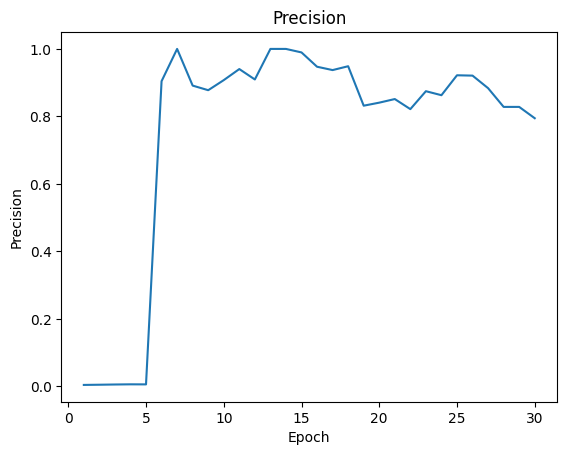

In [ ]:
# Curva de precision conn matplotlib
plt.figure()
plt.plot(df['epoch'], df['metrics/precision(B)'])
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
# promedio precision
print("Precision promedio: ", df['metrics/precision(B)'].mean())

Recall promedio:  0.29063633333333333


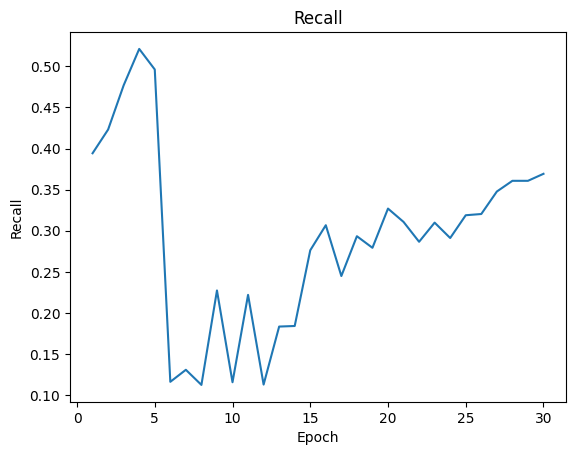

In [ ]:
# CURVA DE RECALL
plt.figure()
plt.plot(df['epoch'], df['metrics/recall(B)'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')

#Promedio recall
print("Recall promedio: ", df['metrics/recall(B)'].mean())

 VAL Box Loss promedio:  1.5979483333333335


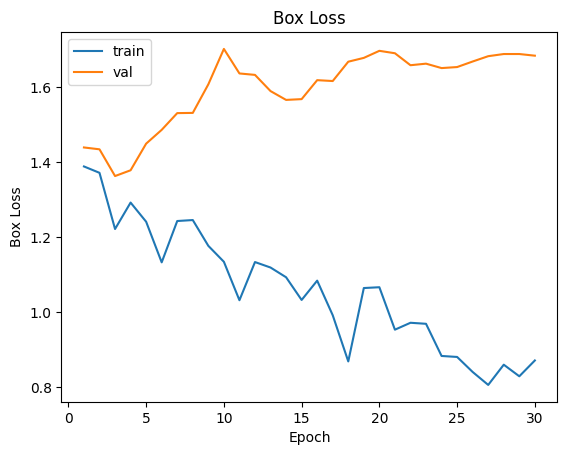

In [ ]:
# gRAFICA BOX_LOSS
# Que tanto se equivoco el modelo al dibujar la caja del objeto
plt.figure()
plt.plot(df['epoch'], df['train/box_loss'],label = 'train')
plt.plot(df['epoch'], df['val/box_loss'],label = 'val')

plt.title('Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.legend()

#Promedio val/boxloss
print(" VAL Box Loss promedio: ", df['val/box_loss'].mean())

Text(0, 0.5, 'Classification Loss')

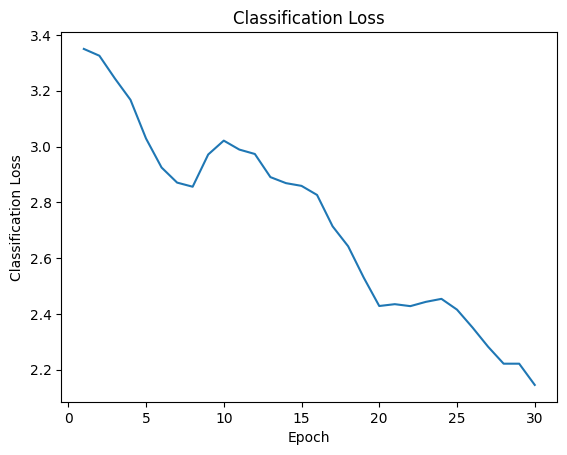

In [ ]:
# Grafica de cls_box
# Que tanto se equivoco el modelo al clasificar
plt.figure()
plt.plot(df['epoch'], df['val/cls_loss'])
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')

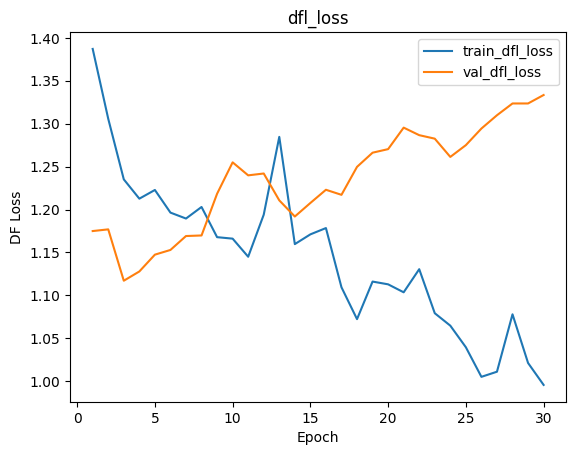

In [ ]:
# grafica train/dfl_loss vs val/dfl1_loss
#Error en la predicción de las coordenadas (detalles finos)
plt.figure()
plt.plot(df['epoch'], df['train/dfl_loss'], label='train_dfl_loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='val_dfl_loss')
plt.title('dfl_loss')
plt.xlabel('Epoch')
plt.ylabel('DF Loss')
plt.legend()

Text(0, 0.5, 'mAP50')

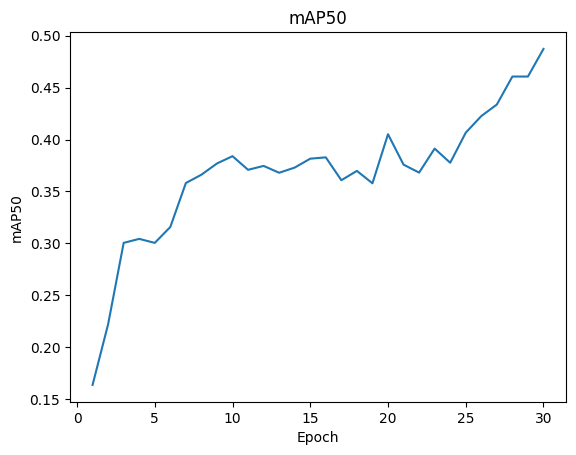

In [ ]:
# Grafica de mAP50
#Precisión media cuando la intersección es al menos 50% (IoU)
plt.figure()
plt.plot(df['epoch'], df['metrics/mAP50(B)'])
plt.title('mAP50')
plt.xlabel('Epoch')
plt.ylabel('mAP50')

mAP50-95 promedio:  0.2294266666666666


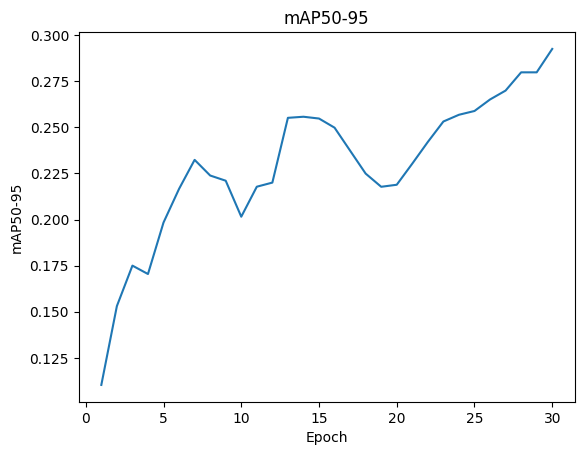

In [ ]:
# Grafica de mAP50-95
plt.figure()
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'])
plt.title('mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP50-95')

#Promedio
print("mAP50-95 promedio: ", df['metrics/mAP50-95(B)'].mean())

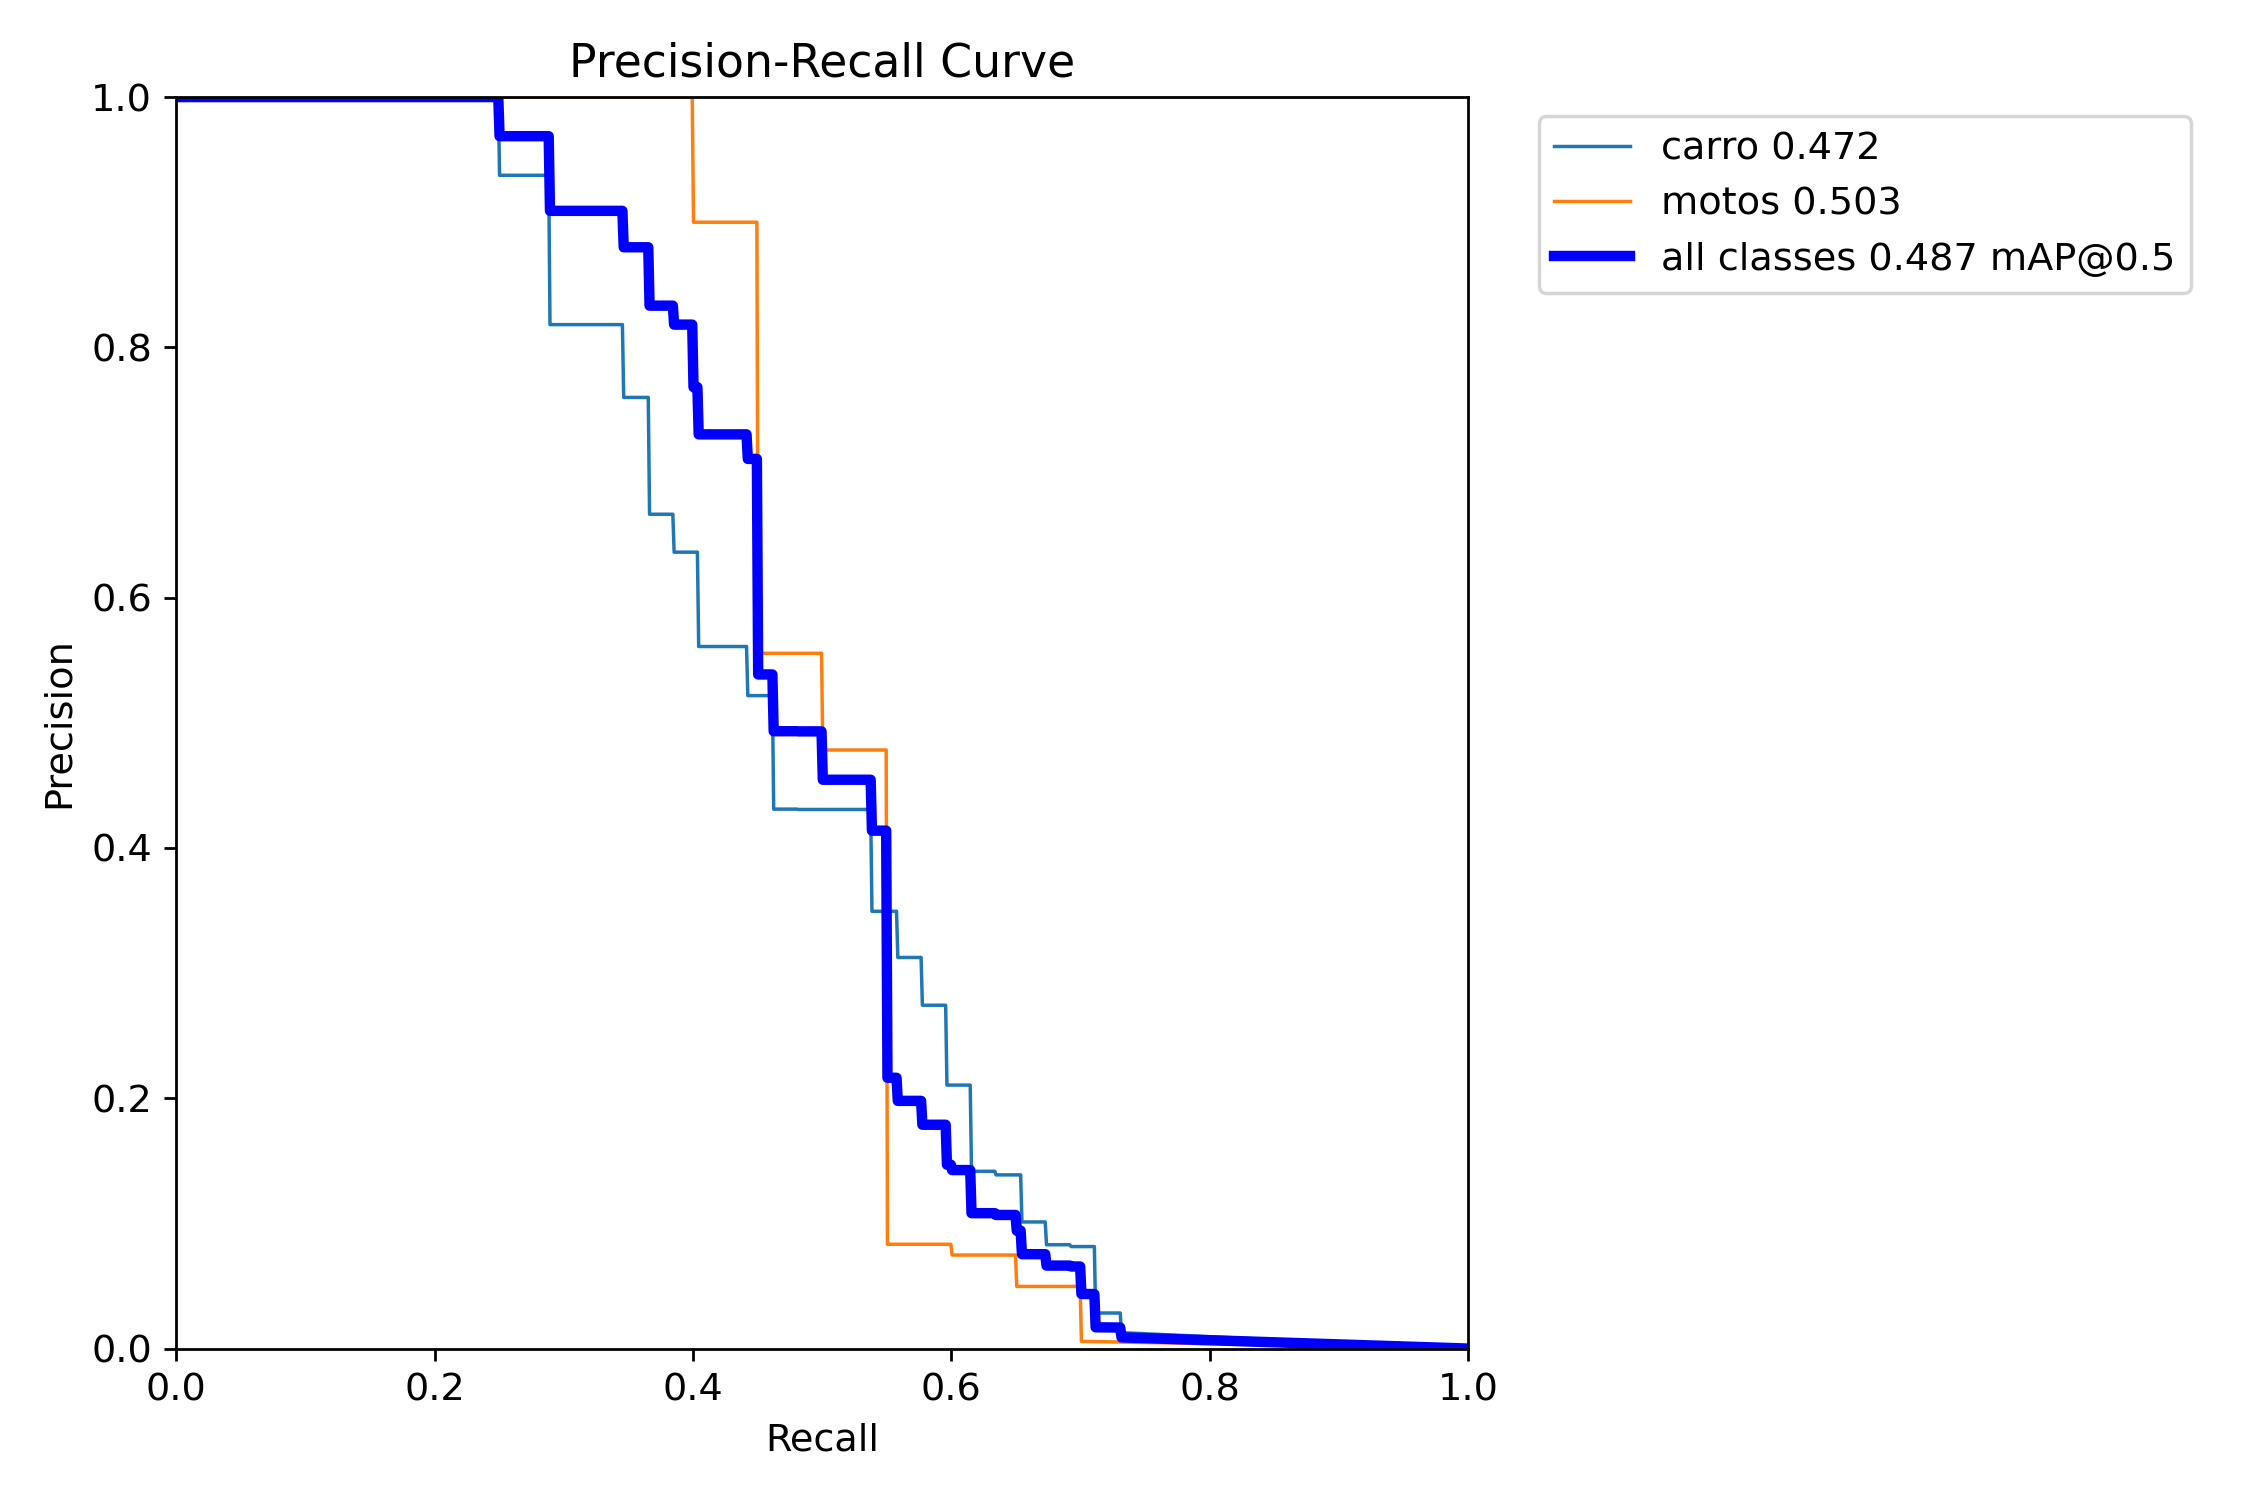

In [ ]:
# 📸 Ver curvas
PR_curve = Image.open("runs/detect/train/PR_curve.png")
display(PR_curve)

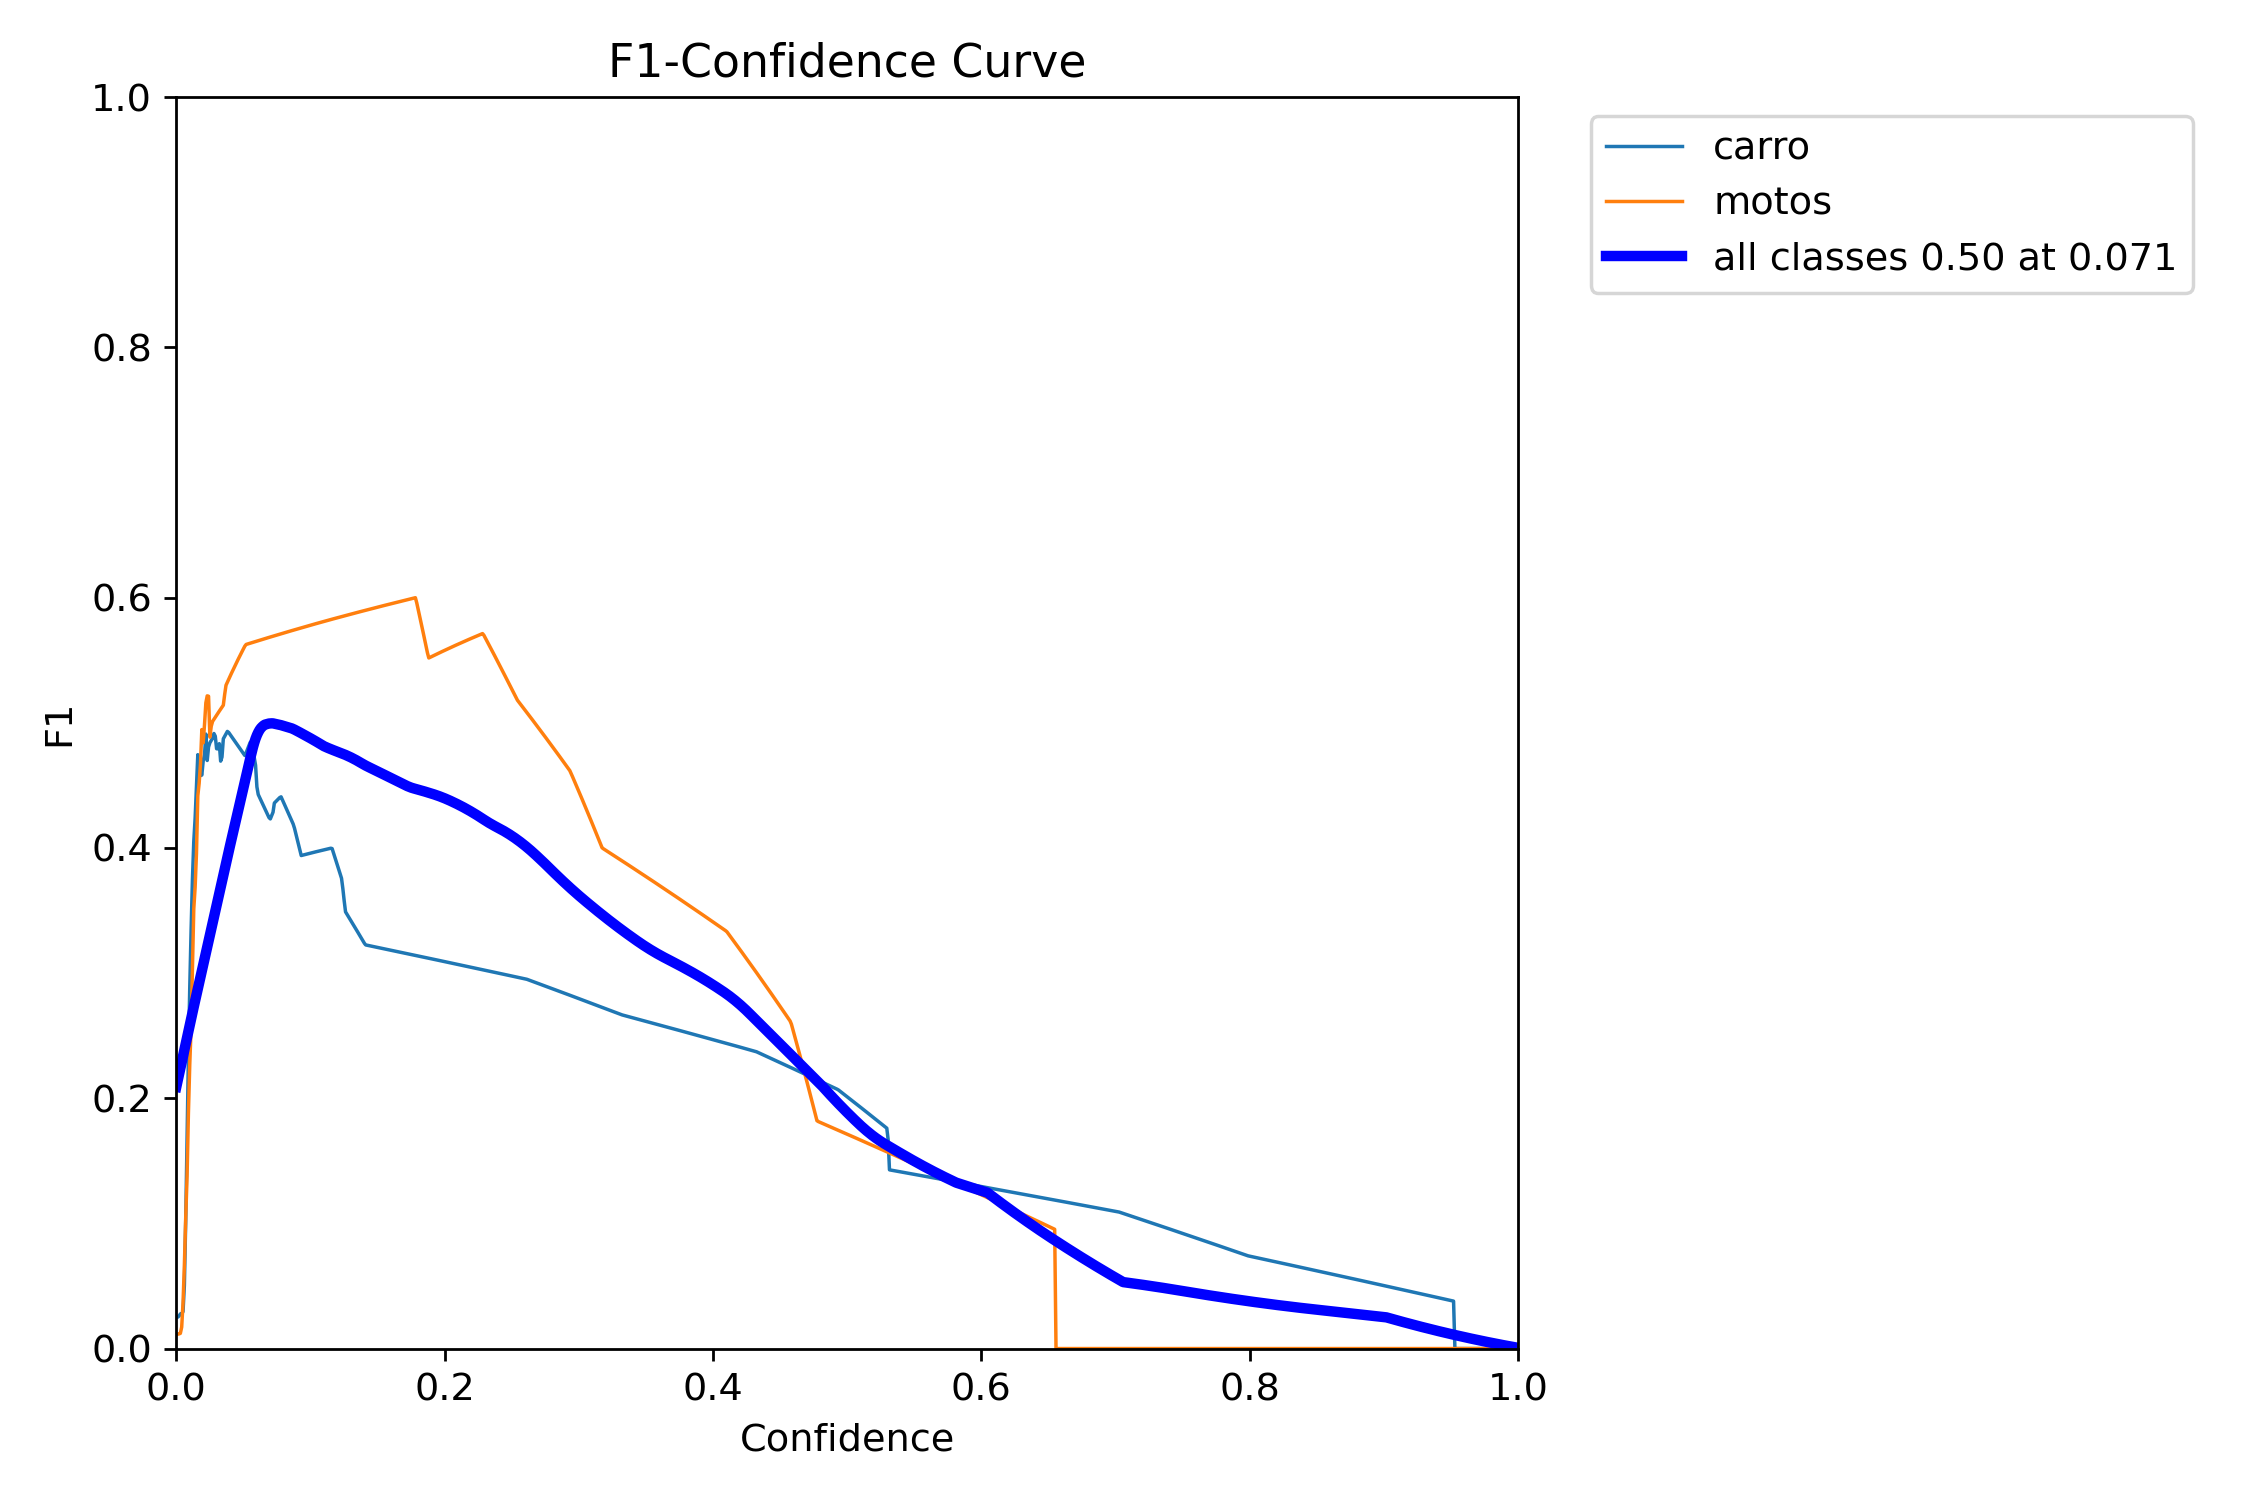

In [ ]:
# F1 Curve
#Saber que tan bien esta equilibrado precision  y recall
# 0 malo , 1 bueno
F1_curve = Image.open("runs/detect/train/F1_curve.png")
display(F1_curve)

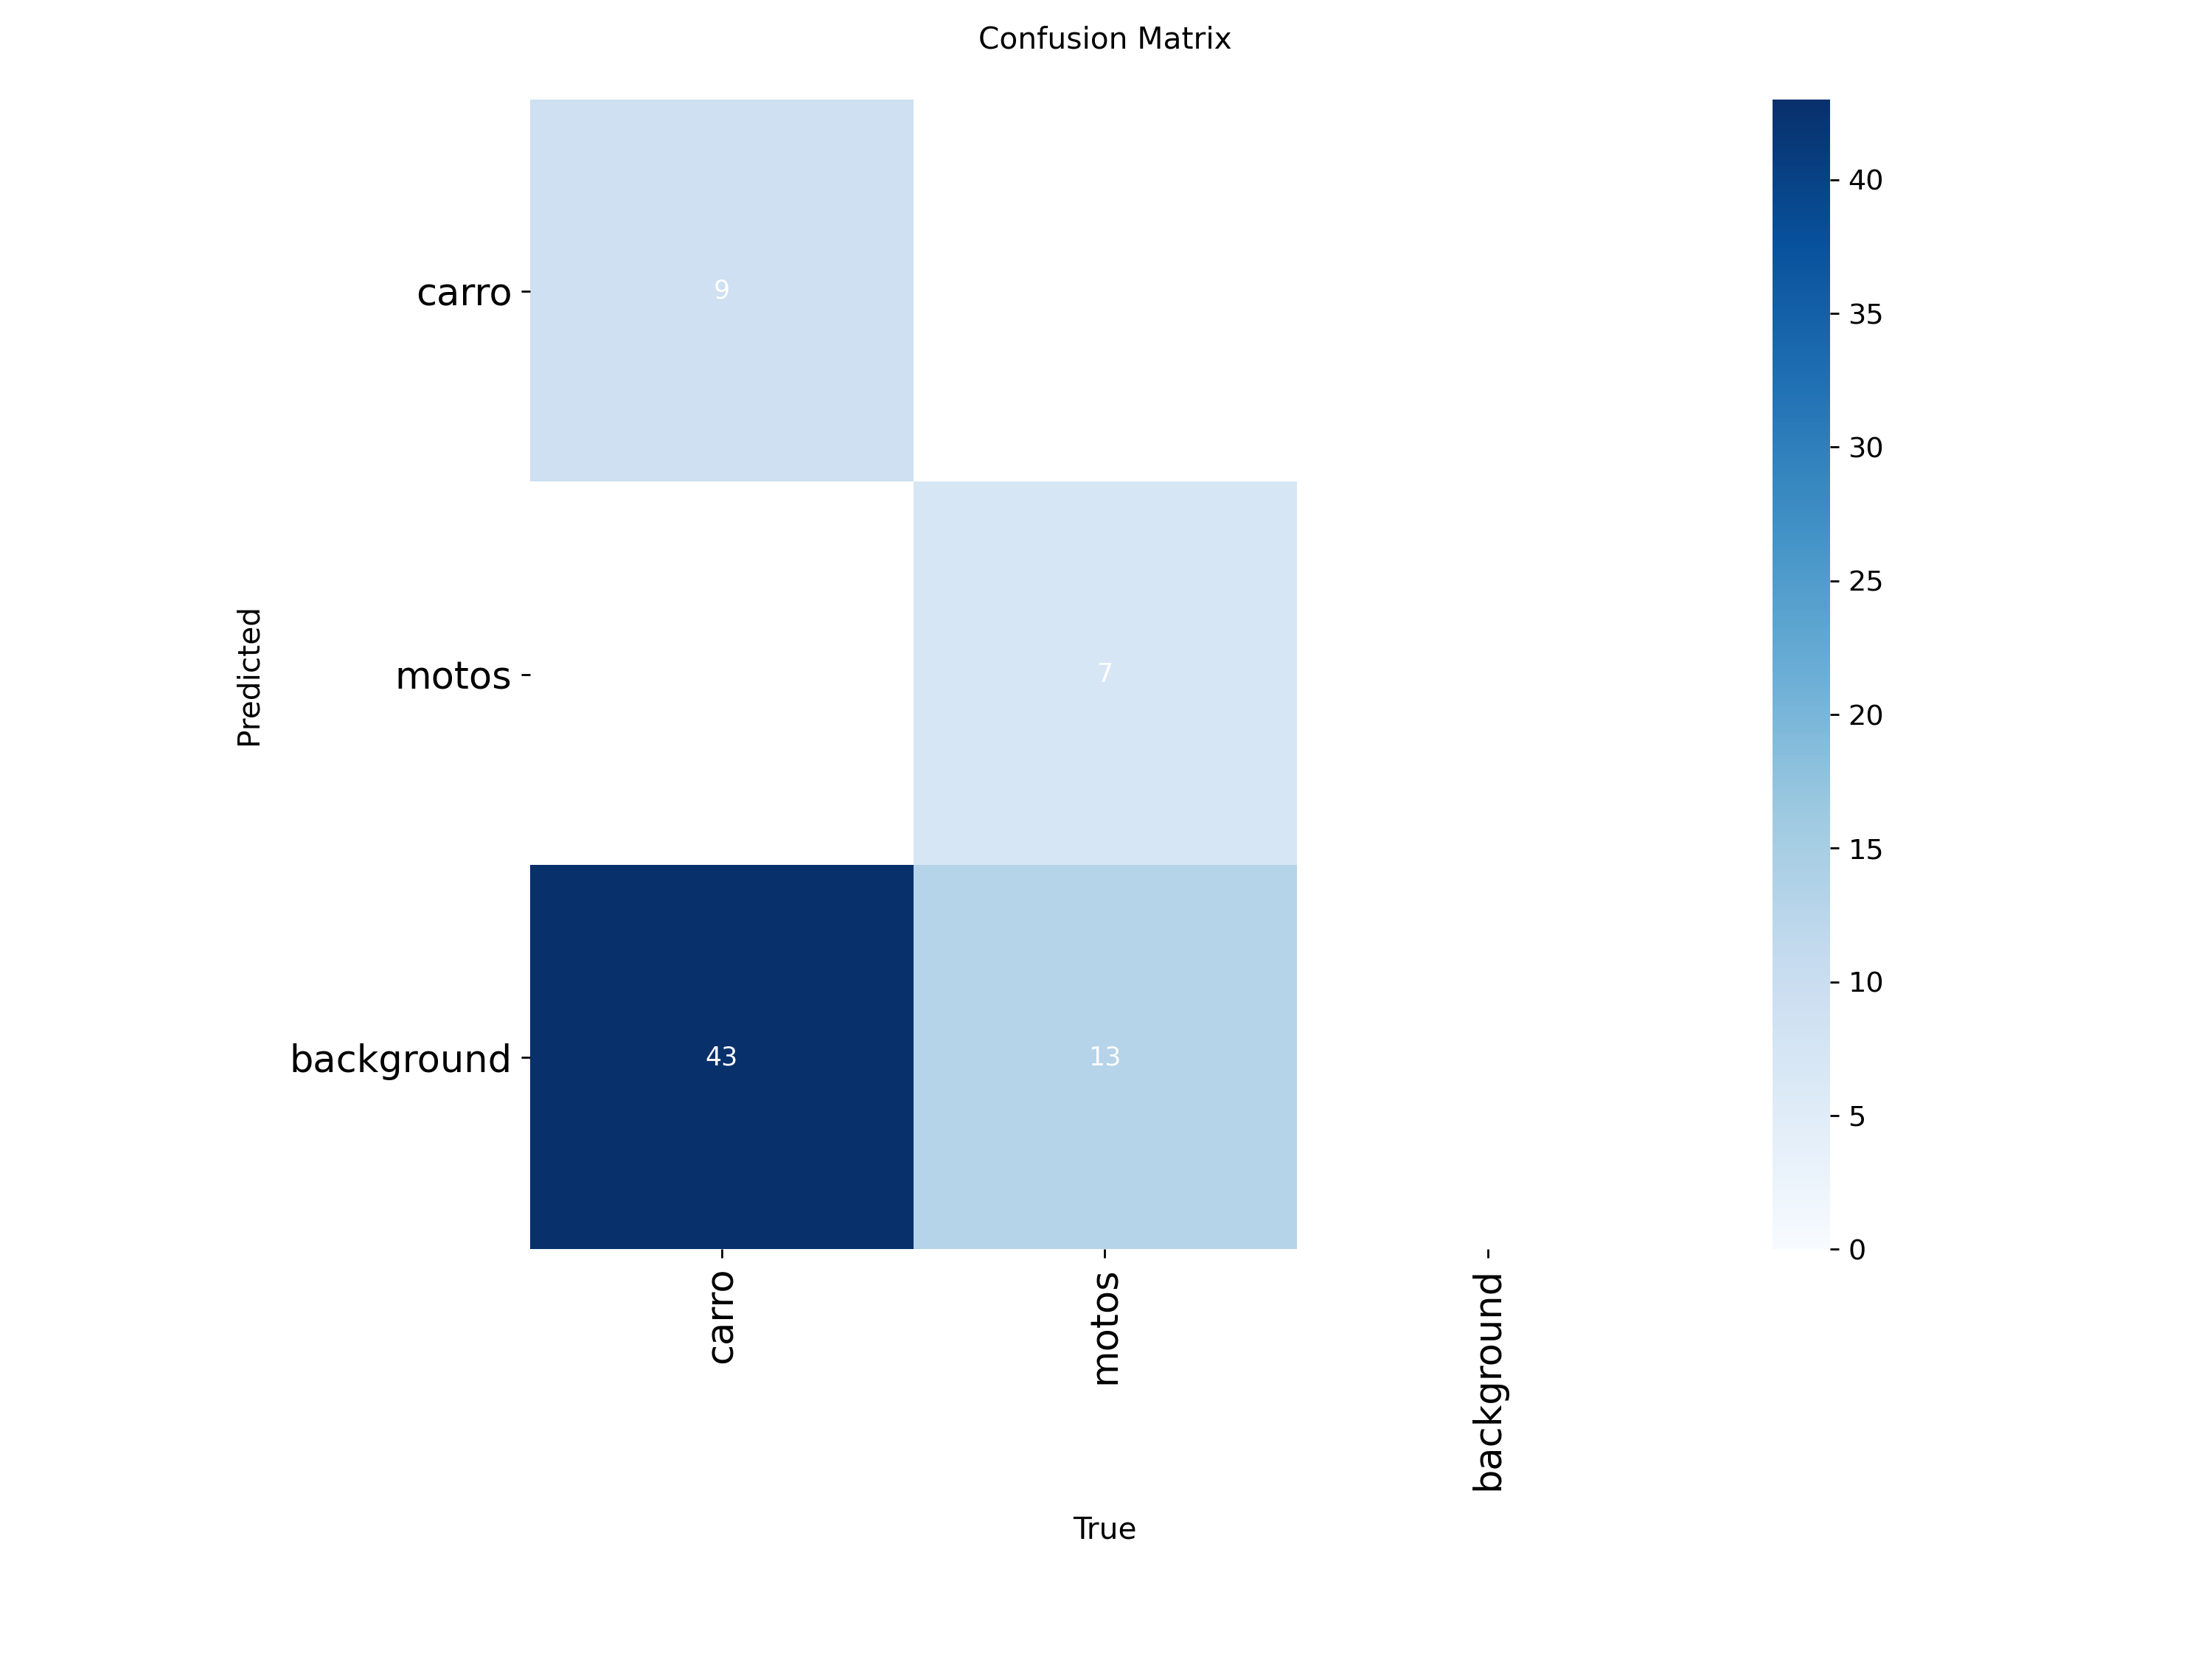

In [ ]:
# Grafica matriz de cinfusion
confusion_matrix = Image.open("runs/detect/train/confusion_matrix.png")
display(confusion_matrix)

📈 Prediccion

In [11]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

In [13]:
# Cargar el modelo
model = YOLO("best.pt")


In [28]:
# Dexcomprimir imagenes
!unzip /content/images.zip -d /content/images

Archive:  /content/images.zip
   creating: /content/images/images/
  inflating: /content/images/images/carromoto_2.jpg  
  inflating: /content/images/images/carromoto_3.jpg  
  inflating: /content/images/images/mot.jpg  
  inflating: /content/images/images/motocarro1_1.jpg  
  inflating: /content/images/images/mot_2.png  


In [32]:
# Mostrar predicción
results = model("/content/images/images/mot_2.png",conf=0.1)



image 1/1 /content/images/images/mot_2.png: 576x640 4 carros, 3 motoss, 35.8ms
Speed: 3.7ms preprocess, 35.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


In [19]:
print(model.names)

{0: 'carro', 1: 'motos'}


In [33]:
print(results[0].boxes)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 1., 1., 1.], device='cuda:0')
conf: tensor([0.5461, 0.5154, 0.4493, 0.3774, 0.1920, 0.1454, 0.1021], device='cuda:0')
data: tensor([[2.7526e+02, 1.3518e+02, 4.1384e+02, 2.5487e+02, 5.4608e-01, 0.0000e+00],
        [2.8029e+02, 3.0664e+01, 3.8341e+02, 1.2442e+02, 5.1545e-01, 0.0000e+00],
        [3.4382e+01, 2.5903e+01, 1.5133e+02, 1.2311e+02, 4.4929e-01, 0.0000e+00],
        [2.4680e+02, 3.1543e+02, 4.2022e+02, 3.7829e+02, 3.7742e-01, 0.0000e+00],
        [1.2550e+02, 2.8457e+02, 1.8595e+02, 3.7371e+02, 1.9202e-01, 1.0000e+00],
        [1.3261e+02, 1.7342e+02, 1.9335e+02, 2.6545e+02, 1.4542e-01, 1.0000e+00],
        [2.0127e+02, 2.4595e+01, 2.4300e+02, 9.9284e+01, 1.0212e-01, 1.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (379, 422)
shape: torch.Size([7, 6])
xywh: tensor([[344.5537, 195.0264, 138.5798, 119.6958],
        [331.8509,  77.5440, 103.1216,  93.7607],
        [ 92.8574

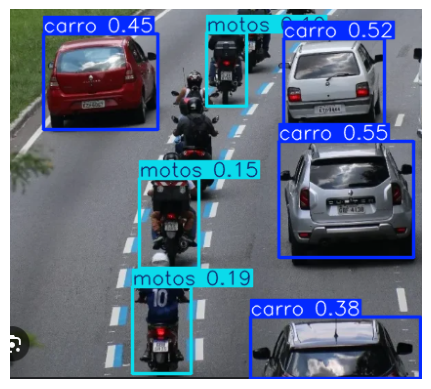

In [34]:
# Cargar imagen con las predicciones renderizadas
rendered_image = results[0].plot()  # Devuelve la imagen con cajas dibujadas

# Mostrar la imagen usando matplotlib
plt.imshow(cv2.cvtColor(rendered_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [8]:
for box in results[0].boxes:
    print(f"Clase: {model.names[int(box.cls)]}, Confianza: {box.conf.item():.2f}")
